
Raw Data Head:

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2014-01-02  17.156704  17.277672  17.122275  17.235799  234684800
2014-01-03  16.779840  17.174382  16.762780  17.148328  392467600
2014-01-06  16.871347  16.960367  16.550936  16.670354  412610800
2014-01-07  16.750681  16.934304  16.684924  16.883435  317209200
2014-01-08  16.856764  16.921900  16.708811  16.712531  258529600

Raw data saved to AAPL_raw.csv

Columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

Cleaned returns saved to AAPL_returns.csv

Summary Statistics of Log Returns:

count    2767.000000
mean        0.000967
std         0.017582
min        -0.137708
25%        -0.007053
50%         0.001000
75%     

C:\Users\kulde\AppData\Local\Temp\ipykernel_25572\1546858550.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


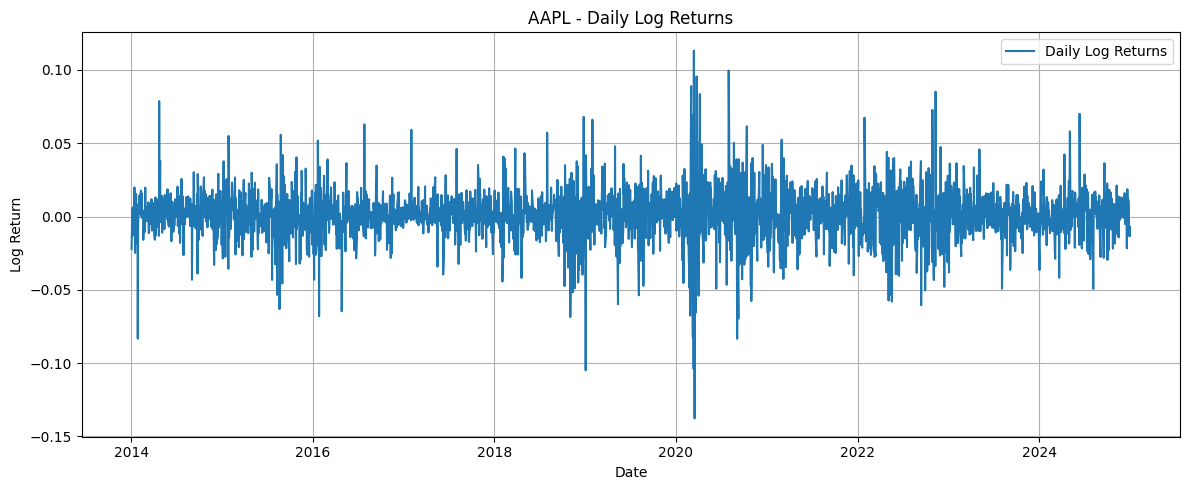

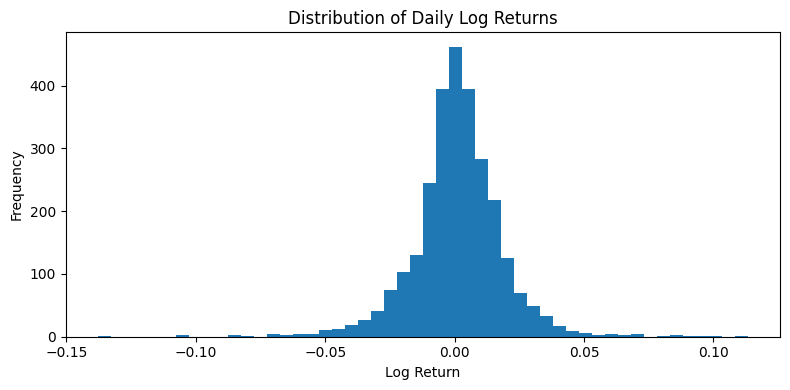


Data collection and preprocessing complete!


In [ ]:
# DATA COLLECTION & PREPROCESSING FOR HMM


import sys
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. PARAMETERS (EDIT THIS PART)

TICKER = "AAPL"                  # Stock symbol
START_DATE = "2014-01-01"        # Start date
END_DATE = "2025-01-01"          # End date

# 2. DATA COLLECTION

print("Downloading data...")

df = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    progress=False
)

print("\nRaw Data Head:\n")
print(df.head())

# Save raw data
df.to_csv(f"{TICKER}_raw.csv")
print(f"\nRaw data saved to {TICKER}_raw.csv")

# 3. PREPROCESSING

print("\nColumns:", df.columns)

# Robustly find an adjusted/close price column (handles MultiIndex or flat columns)
try:
    if isinstance(df.columns, pd.MultiIndex):
        # collect candidate columns that mention 'adj' or 'close'
        candidates = [c for c in df.columns
                      if any(substr in str(part).lower() for part in c for substr in ("adj", "close"))]
        if not candidates:
            # fallback: try any column whose name contains 'close' in any level
            candidates = [c for c in df.columns if any('close' in str(part).lower() for part in c)]
        if not candidates:
            sys.exit(f"'Adj Close' not found in MultiIndex columns. Columns: {list(df.columns)}")
        adj_col = candidates[0]
        adj_close = df[adj_col].dropna()
        # if selecting yields a DataFrame, pick the first series
        if isinstance(adj_close, pd.DataFrame):
            adj_close = adj_close.iloc[:, 0].dropna()
    else:
        # flat columns
        if "Adj Close" in df.columns:
            adj_close = df["Adj Close"].dropna()
        elif "Close" in df.columns:
            adj_close = df["Close"].dropna()
        else:
            # try case-insensitive search
            matches = [c for c in df.columns if "close" in str(c).lower() or "adj" in str(c).lower()]
            if matches:
                adj_close = df[matches[0]].dropna()
            else:
                sys.exit(f"'Adj Close' or 'Close' column not found. Columns: {list(df.columns)}")
except Exception as e:
    sys.exit(f"Error selecting adjusted/close prices: {e}")

# Compute daily log returns
returns = np.log(adj_close).diff().dropna()

# Build a clean dataframe for results
df_clean = pd.DataFrame({
    "AdjClose": adj_close.loc[returns.index],
    "LogReturn": returns
})

# Save cleaned returns
df_clean.to_csv(f"{TICKER}_returns.csv")
print(f"\nCleaned returns saved to {TICKER}_returns.csv")

# 4. SUMMARY STATISTICS

print("\nSummary Statistics of Log Returns:\n")
print(df_clean["LogReturn"].describe())

# 5. VISUALIZATION

plt.figure(figsize=(12,5))
plt.plot(df_clean.index, df_clean["LogReturn"], label="Daily Log Returns")
plt.title(f"{TICKER} - Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. OPTIONAL: HISTOGRAM

plt.figure(figsize=(8,4))
plt.hist(df_clean["LogReturn"], bins=50)
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("\nData collection and preprocessing complete!")




Loading preprocessed returns...

Loaded returns:
             AdjClose  LogReturn
Date                            
2014-01-03  16.779840  -0.022211
2014-01-06  16.871347   0.005439
2014-01-07  16.750681  -0.007178
2014-01-08  16.856764   0.006313
2014-01-09  16.641500  -0.012852

Fitting Gaussian HMM with 2 hidden states...

Model training complete.

Predicting hidden states using Viterbi algorithm...

Predicted hidden states saved to AAPL_HMM_states.csv

========== HIDDEN STATE ANALYSIS ==========

State 0:
  Mean return     = 0.001524
  Std deviation   = 0.011786
  Variance        = 0.000139
  Data proportion = 0.7976

State 1:
  Mean return     = -0.000811
  Std deviation   = 0.029646
  Variance        = 0.000879
  Data proportion = 0.2024

Transition Matrix:
[[0.96200017 0.03799983]
 [0.12136975 0.87863025]]


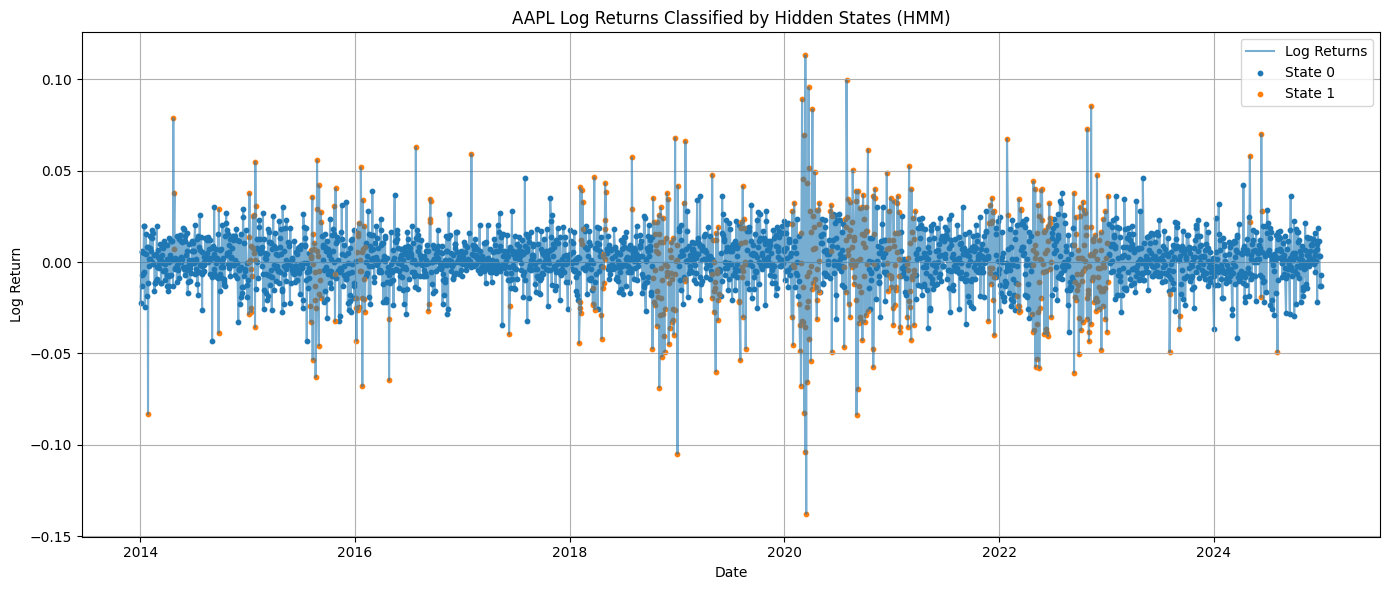


HMM model fitting and analysis complete!



In [ ]:

# PART 2: GAUSSIAN HIDDEN MARKOV MODEL (HMM)


# Install hmmlearn if not installed:
# pip install hmmlearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# 1. LOAD THE PREPROCESSED DATA

TICKER = "AAPL"

print("\nLoading preprocessed returns...")
df_clean = pd.read_csv(f"{TICKER}_returns.csv", index_col=0, parse_dates=True)

returns = df_clean["LogReturn"].values.reshape(-1, 1)

print("\nLoaded returns:")
print(df_clean.head())


# 2. CONFIGURE & FIT HMM MODEL

N_STATES = 2          # You can try 2, 3, or 4 states
COV_TYPE = "full"     # "diag" recommended; "full" also possible

print(f"\nFitting Gaussian HMM with {N_STATES} hidden states...")

model = GaussianHMM(
    n_components=N_STATES,
    covariance_type=COV_TYPE,
    n_iter=300,
    random_state=42
)

model.fit(returns)

print("\nModel training complete.\n")


# 3. DECODE HIDDEN STATES

print("Predicting hidden states using Viterbi algorithm...")

states = model.predict(returns)
df_clean["State"] = states

df_clean.to_csv(f"{TICKER}_HMM_states.csv")
print(f"\nPredicted hidden states saved to {TICKER}_HMM_states.csv")


# 4. PARAMETER ANALYSIS

print("\n========== HIDDEN STATE ANALYSIS ==========\n")

means = model.means_.flatten()
variances = model.covars_.flatten()
std_dev = np.sqrt(variances)

for i in range(N_STATES):
    print(f"State {i}:")
    print(f"  Mean return     = {means[i]:.6f}")
    print(f"  Std deviation   = {std_dev[i]:.6f}")
    print(f"  Variance        = {variances[i]:.6f}")
    print(f"  Data proportion = {np.mean(states == i):.4f}")
    print()

# Transition matrix
print("Transition Matrix:")
print(model.transmat_)


# 5. VISUALIZATION OF STATES

plt.figure(figsize=(14, 6))
plt.plot(df_clean.index, df_clean["LogReturn"], label="Log Returns", alpha=0.6)

# Color-code returns by hidden state
colors = ["red", "blue", "green", "purple"]
for i in range(N_STATES):
    idx = df_clean["State"] == i
    plt.scatter(
        df_clean.index[idx],
        df_clean["LogReturn"][idx],
        s=10,
        label=f"State {i}"
    )

plt.title(f"{TICKER} Log Returns Classified by Hidden States (HMM)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nHMM model fitting and analysis complete!\n")




========= TIME PERIODS FOR EACH STATE =========

State 0: first seen on 2014-01-03, last seen on 2024-12-31
State 0 count: 2207 days

State 1: first seen on 2014-01-28, last seen on 2024-08-05
State 1 count: 560 days



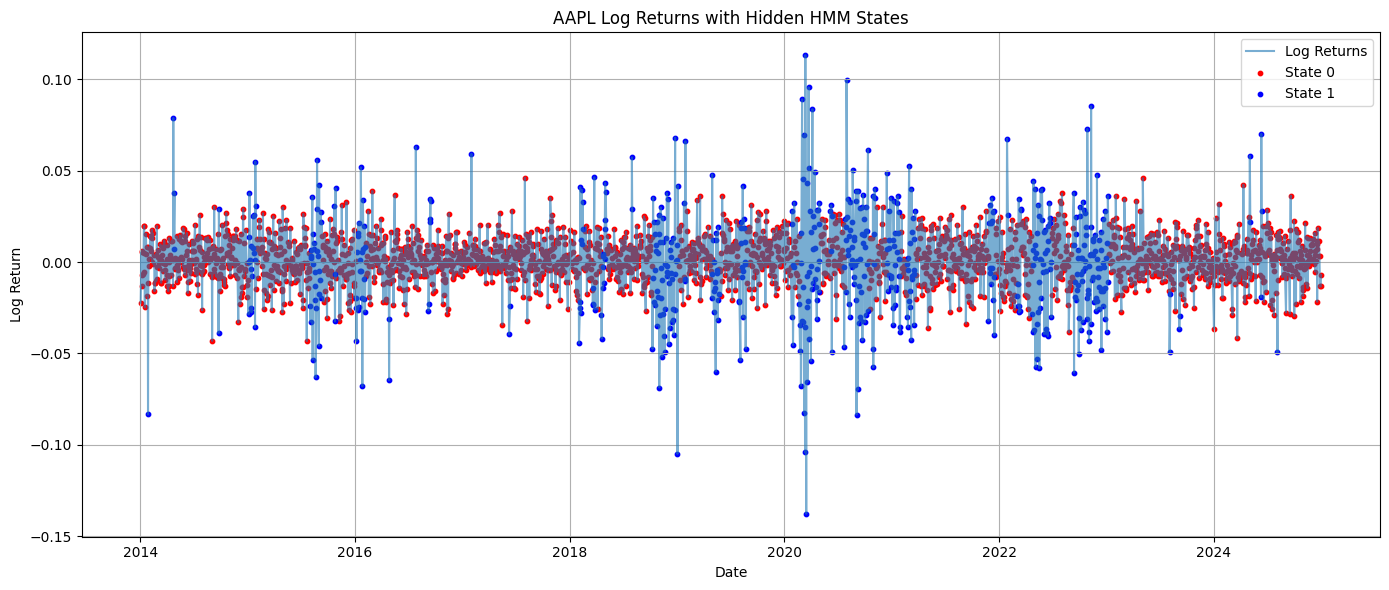


========= TRANSITION MATRIX =========

[[0.96200017 0.03799983]
 [0.12136975 0.87863025]]

Interpretation:
State 0: stays in same state with probability 0.9620
State 1: stays in same state with probability 0.8786


In [ ]:
# PART 3: INTERPRETATION AND INFERENCE OF HMM STATES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load HMM outputs
TICKER = "AAPL"
df_states = pd.read_csv(f"{TICKER}_HMM_states.csv", index_col=0, parse_dates=True)

states = df_states["State"].values

 
# 1. IDENTIFY TIME PERIODS PER STATE

print("\n========= TIME PERIODS FOR EACH STATE =========\n")

for s in sorted(df_states["State"].unique()):
    period_start = df_states[df_states["State"] == s].index[0]
    period_end = df_states[df_states["State"] == s].index[-1]
    print(f"State {s}: first seen on {period_start.date()}, last seen on {period_end.date()}")
    print(f"State {s} count: {sum(states == s)} days")
    print()

# 2. VISUALIZE STATES ON RETURNS

plt.figure(figsize=(14,6))
plt.plot(df_states.index, df_states["LogReturn"], label="Log Returns", alpha=0.6)

colors = ["red", "blue", "green", "purple"]

for s in sorted(df_states["State"].unique()):
    idx = df_states["State"] == s
    plt.scatter(
        df_states.index[idx],
        df_states["LogReturn"][idx],
        s=10,
        color=colors[s],
        label=f"State {s}"
    )

plt.title(f"{TICKER} Log Returns with Hidden HMM States")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3. TRANSITION MATRIX ANALYSIS

print("\n========= TRANSITION MATRIX =========\n")
print(model.transmat_)

print("\nInterpretation:")
for i in range(model.n_components):
    stay_prob = model.transmat_[i, i]
    print(f"State {i}: stays in same state with probability {stay_prob:.4f}")





Plotting price chart with hidden states...


C:\Users\kulde\AppData\Local\Temp\ipykernel_25572\1176005291.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_prices = pd.read_csv(raw_file, index_col=0, parse_dates=True)


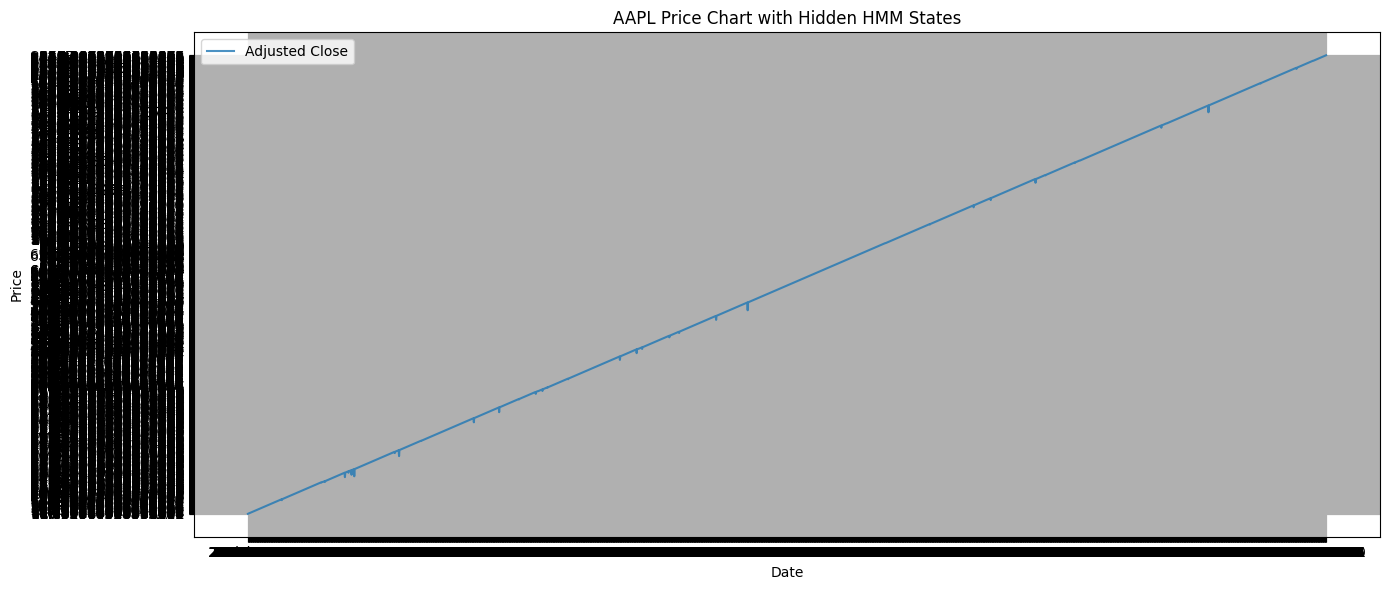


Plotting returns with shaded regimes...


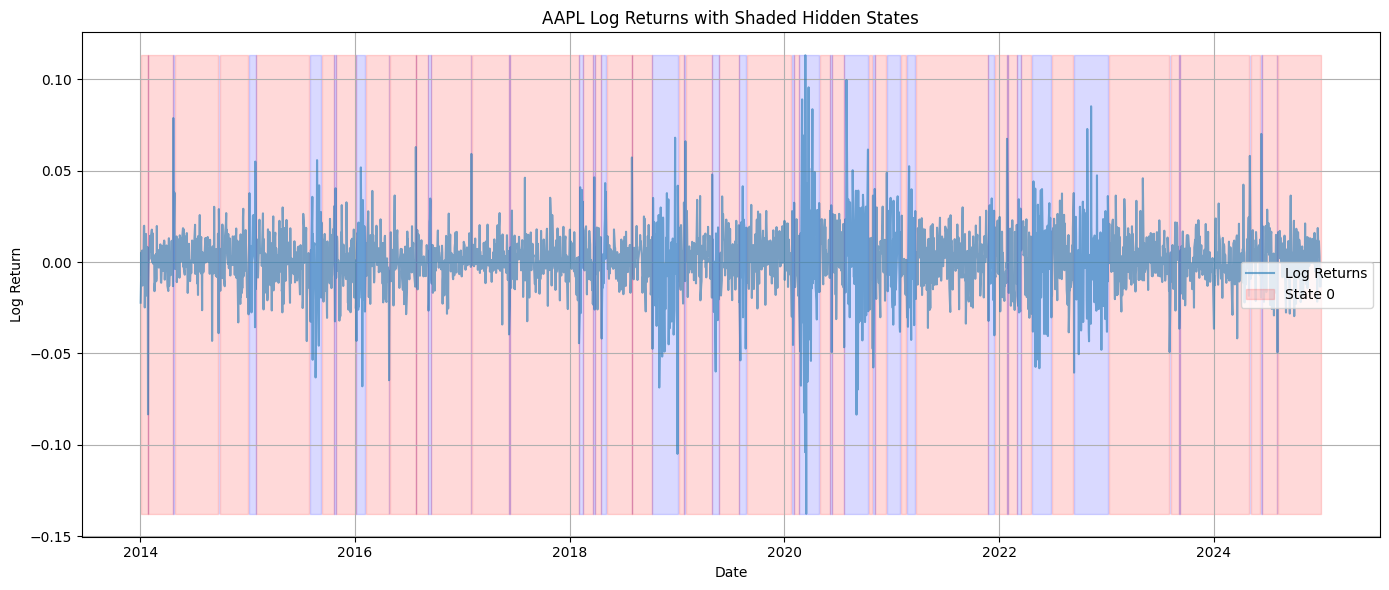


Evaluating model performance for K = 2, 3, 4...



Model is not converging.  Current: 7645.088279136899 is not greater than 7645.098231517263. Delta is -0.009952380364666169


   States (K)  Log-Likelihood           AIC           BIC
0           2     7579.985543 -15147.971086 -15112.417972
1           3     7577.409909 -15130.819818 -15059.713591
2           4     7645.060761 -15250.121522 -15131.611143

Saved evaluation table to: AAPL_HMM_model_evaluation.csv

================ INTERPRETATION GUIDE ================

1. Use the price chart to see which states correspond to bull/bear periods.
2. The returns shading indicates volatility bursts — higher variance = high volatility regime.
3. Use the table (AIC/BIC/log-likelihood) to decide the best number of states.
4. If K=2 gives clean separation, it's good for a simple bull/bear regime model.
5. If K=3 or 4 splits volatility into multiple clusters (calm, medium, extreme), discuss it.

Part 4 complete!



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

TICKER = "AAPL"

# Load returns + states
states_file = f"{TICKER}_HMM_states.csv"
if not os.path.exists(states_file):
    raise FileNotFoundError(f"{states_file} not found. Run earlier cells to produce it.")

df = pd.read_csv(states_file, index_col=0, parse_dates=True)

# basic checks
if "LogReturn" not in df.columns or "State" not in df.columns:
    raise KeyError("Expected columns 'LogReturn' and 'State' in the states CSV.")

# 1. VISUALIZATION: PRICE CHART WITH HIDDEN STATES

print("\nPlotting price chart with hidden states...")

raw_file = f"{TICKER}_raw.csv"
if not os.path.exists(raw_file):
    raise FileNotFoundError(f"{raw_file} not found. Run data-collection cell first.")

df_prices = pd.read_csv(raw_file, index_col=0, parse_dates=True)

def find_adj_close(series_df):
    cols = series_df.columns
    # MultiIndex case
    if isinstance(cols, pd.MultiIndex):
        # prefer level names containing adj/close
        for c in cols:
            if any("adj" in str(part).lower() or "close" in str(part).lower() for part in c):
                s = series_df[c]
                return s.iloc[:,0].dropna() if isinstance(s, pd.DataFrame) else s.dropna()
        # fallback: try first numeric-looking column
        first = series_df.iloc[:,0]
        return first.dropna()
    # flat columns: common names
    for name in ("Adj Close", "AdjClose", "Adj_Close", "Close", ("Close","")):
        if name in cols:
            return series_df[name].dropna()
    # case-insensitive substring match
    for c in cols:
        if "adj" in str(c).lower() or "close" in str(c).lower():
            return series_df[c].dropna()
    # fallback to first numeric column
    numeric_cols = series_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols):
        return series_df[numeric_cols[0]].dropna()
    raise KeyError(f"Could not find an adjusted/close price column. Columns: {list(cols)}")

adj_close = find_adj_close(df_prices)

plt.figure(figsize=(14,6))
plt.plot(adj_close.index, adj_close.values, label="Adjusted Close", alpha=0.8)

colors = ["red", "blue", "green", "purple", "orange", "brown"]
n_colors = len(colors)

# Color-code price points by state (safe reindex)
for s in sorted(df["State"].unique()):
    idx = df["State"] == s
    dates = df.index[idx]
    pts = adj_close.reindex(dates).dropna()
    if pts.empty:
        continue
    plt.scatter(pts.index, pts.values, s=8, color=colors[s % n_colors], label=f"State {s}")

plt.title(f"{TICKER} Price Chart with Hidden HMM States")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. VISUALIZATION: RETURNS WITH SHADED REGIMES

print("\nPlotting returns with shaded regimes...")

plt.figure(figsize=(14,6))
plt.plot(df.index, df["LogReturn"], label="Log Returns", alpha=0.6)

ymin = df["LogReturn"].min()
ymax = df["LogReturn"].max()

for s in sorted(df["State"].unique()):
    mask = (df["State"] == s).values
    # fill_between requires index-aligned arrays
    plt.fill_between(df.index, ymin, ymax, where=mask, alpha=0.15,
                     color=colors[s % n_colors], label=f"State {s}" if s == sorted(df["State"].unique())[0] else "")

plt.title(f"{TICKER} Log Returns with Shaded Hidden States")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3. MODEL EVALUATION FOR DIFFERENT K VALUES

print("\nEvaluating model performance for K = 2, 3, 4...\n")

returns = df["LogReturn"].dropna().values.reshape(-1,1)
if returns.size == 0:
    raise ValueError("No returns available for model evaluation.")

results = []
for K in [2, 3, 4]:
    model_k = GaussianHMM(n_components=K, covariance_type="diag", n_iter=200, random_state=42)
    model_k.fit(returns)
    logL = model_k.score(returns)
    # approximate parameter count: K means + K variances + K*(K-1) transition probs
    param_count = K + K + K * (K - 1)
    AIC = -2 * logL + 2 * param_count
    BIC = -2 * logL + param_count * np.log(returns.shape[0])
    results.append([K, logL, AIC, BIC])

df_eval = pd.DataFrame(results, columns=["States (K)", "Log-Likelihood", "AIC", "BIC"])
print(df_eval)

df_eval.to_csv(f"{TICKER}_HMM_model_evaluation.csv", index=False)
print("\nSaved evaluation table to:", f"{TICKER}_HMM_model_evaluation.csv")

# Interpretation guidance

print("\n================ INTERPRETATION GUIDE ================\n")
print("1. Use the price chart to see which states correspond to bull/bear periods.")
print("2. The returns shading indicates volatility bursts — higher variance = high volatility regime.")
print("3. Use the table (AIC/BIC/log-likelihood) to decide the best number of states.")
print("4. If K=2 gives clean separation, it's good for a simple bull/bear regime model.")
print("5. If K=3 or 4 splits volatility into multiple clusters (calm, medium, extreme), discuss it.")
print("\nPart 4 complete!\n")


In [ ]:
# PART 5: CONCLUSIONS AND INSIGHTS

import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

TICKER = "AAPL"

# Load processed data & model states
df_states = pd.read_csv(f"{TICKER}_HMM_states.csv", index_col=0, parse_dates=True)
returns = df_states["LogReturn"].values.reshape(-1, 1)

# 1. RE-FIT FINAL MODEL USING BEST K (Choose best manually)


BEST_K = 2   # You can change this based on AIC/BIC results

print(f"\nTraining final HMM model with K = {BEST_K}")

model = GaussianHMM(
    n_components=BEST_K,
    covariance_type="diag",
    n_iter=300,
    random_state=42
)

model.fit(returns)
states = model.predict(returns)

means = model.means_.flatten()
variances = model.covars_.flatten()
stds = np.sqrt(variances)

print("\n========== MARKET REGIME INTERPRETATION ==========\n")

for i in range(BEST_K):
    print(f"State {i}:")
    print(f"  Mean return     : {means[i]:.6f}")
    print(f"  Std deviation   : {stds[i]:.6f}")
    print(f"  Variance        : {variances[i]:.6f}")
    print(f"  Data proportion : {np.mean(states == i):.4f}")
    if stds[i] < np.median(stds):
        print("  → Interpretation: LOW VOLATILITY (Calm / Bullish regime)")
    else:
        print("  → Interpretation: HIGH VOLATILITY (Risky / Bearish regime)")
    print()


# 2. FUTURE STATE PREDICTION USING TRANSITION MATRIX

print("\n========== FUTURE STATE PREDICTION ==========\n")

trans = model.transmat_

print("Transition Matrix:")
print(trans)

# Most recent state predicted by the model
current_state = states[-1]
print(f"\nMost recent inferred state: State {current_state}")

# One-step ahead prediction: probability of each next state
next_state_probs = trans[current_state]

print("\nOne-step-ahead future state probabilities:")
for i, p in enumerate(next_state_probs):
    print(f"  P(State {i} tomorrow) = {p:.4f}")

# Likely future state
likely_next_state = np.argmax(next_state_probs)
print(f"\nMost likely next state: State {likely_next_state}")


# 3. MULTI-STEP FORECASTING (OPTIONAL BUT USEFUL)

steps_ahead = 5
multi_step_probs = np.linalg.matrix_power(trans, steps_ahead)[current_state]

print(f"\nProbability distribution {steps_ahead} days ahead:")
for i, p in enumerate(multi_step_probs):
    print(f"  P(State {i} in {steps_ahead} days) = {p:.4f}")

print("\nPart 5 complete!\n")



Training final HMM model with K = 2

========== MARKET REGIME INTERPRETATION ==========

State 0:
  Mean return     : 0.001524
  Std deviation   : 0.011786
  Variance        : 0.000139
  Data proportion : 0.7976
  → Interpretation: LOW VOLATILITY (Calm / Bullish regime)

State 1:
  Mean return     : -0.000811
  Std deviation   : 0.029646
  Variance        : 0.000879
  Data proportion : 0.2024
  → Interpretation: HIGH VOLATILITY (Risky / Bearish regime)


========== FUTURE STATE PREDICTION ==========

Transition Matrix:
[[0.96200017 0.03799983]
 [0.12136975 0.87863025]]

Most recent inferred state: State 0

One-step-ahead future state probabilities:
  P(State 0 tomorrow) = 0.9620
  P(State 1 tomorrow) = 0.0380

Most likely next state: State 0

Probability distribution 5 days ahead:
  P(State 0 in 5 days) = 0.8617
  P(State 1 in 5 days) = 0.1383

Part 5 complete!

